# Install libraries & version check
Code pipeline from the PNAS 2020 paper by Jiawei Zhuang et al. 

In [1]:
%%capture
!pip install -U numpy==1.18.5
!pip install h5py==2.10.0

In [2]:
'Comment above cell and restart runtime'
'Upload 3 arrays for OOA analysis'

'Upload 3 arrays for OOA analysis'

In [1]:
'Check numpys version BEFORE and AFTER runtime restart'
import numpy as np
import matplotlib.pyplot as plt
print(np.__version__)


1.18.5


## In this notebook, I compare the working of : <br> 
PNAS library model class <br> 
v.s. <br> 
My Custom model class <br> 
My main focus is analyzing the Polynomial acuuracy constraint, although I will analyze the entire network step-by-step.

# Setup

In [2]:
%%capture
# !git clone https://github.com/aditya5252/Multiprocessor_Advection_.git
!pip install git+https://github.com/JiaweiZhuang/data-driven-pdes@fix-beam
%tensorflow_version 1.x

import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from google.colab import files  # colab-specific utilities; comment out when running locally

tf.enable_eager_execution()

tf.__version__, tf.keras.__version__
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils
from datadrivenpdes.core import geometry
from datadrivenpdes.core import polynomials
# tf.keras.backend.set_floatx('float32')
import copy

In [3]:
def CD2_data(linear,init,c,ntime,N_x,delt,delx):
    data_ls=[]
    u=init
    if linear == True: 
        for step in range(ntime):
            data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
            unew=u.copy() 
            for i in range(1,N_x-1):
                unew[i]=u[i] + delt*( -c*(u[i+1]-u[i-1])/(2*delx) )  ## B.D. model
            unew[0]=u[0] + delt*( -c*(u[1]-u[N_x-2])/(2*delx) )
            unew[N_x-1]=unew[0] 
            u=unew
    elif linear == False:
        pass
    data_sol=np.stack(data_ls)
    return data_sol

def upwind_data(linear,init,c,ntime,N_x,delt,delx):
  data_ls=[]
  u=init
  if ((linear == True) and (c>0)): ## Apply B.D. with preiodic boundary conditions
      for step in range(ntime):
          data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
          unew=u.copy() 
          for i in range(1,N_x-1):
              unew[i]=u[i] + delt*( -c*(u[i]-u[i-1])/delx )  ## B.D. model
          unew[0]=u[0] + delt*( -c*(u[0]-u[N_x-2])/delx )
          unew[N_x-1]=unew[0] 
          u=unew

  elif ((linear == True) and (c<=0)): ## Apply F.D. with preiodic boundary conditions
      for step in range(ntime):
          data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
          unew=u.copy() 
          for i in range(1,N_x-1):
              unew[i]=u[i] + delt*( -c*(u[i+1]-u[i])/delx )  ## F.D. model
          unew[0]=u[0] + delt*( -c*(u[1]-u[0])/delx )
          unew[N_x-1]=unew[0] 
          u=unew
  else:
      print(c)
      for step in range(ntime):
          data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
          unew=u.copy()
          for i in range(1,N_x-1):
              if u[i]>0:
                  unew[i]=u[i] + delt*( -u[i]*(u[i]-u[i-1])/delx)
              else:
                  unew[i]=u[i] + delt*( -u[i]*(u[i+1]-u[i])/delx)
          if u[0]>0:
              unew[0]=u[0] + delt*( -u[0]*(u[0]-u[N_x-2])/delx)
          else:
              unew[0]=u[0] + delt*( -u[0]*(u[1]-u[0])/delx ) 
              
          unew[N_x-1]=unew[0]   
          u=unew
  data_sol=np.stack(data_ls)
  return data_sol

In [4]:
def ic(A,K,PHI,x_mesh):
  u=np.zeros_like(x_mesh)
  for A1,k1 in zip(A,K):
    for phi1 in PHI:
      u+= A1*np.sin(k1*x_mesh + phi1)
  return u

def solution_data(A,K,PHI,x_mesh,ntime,delt):
  # data_ls=[ u_ana[i]+=  amp[k1]*exp(-kappa[k1]*kappa[k1]*nu*tEnd)*sin(kappa[k1]*(x[i]-cx*tEnd)+phi[k2]) for i in range(ntime)]
  data_ls=[]
  for step in range(ntime):
    u=np.zeros_like(x_mesh)
    for A1,k1 in zip(A,K):
      for phi1 in PHI:
        u+= A1*np.sin(k1*(x_mesh-step*delt) + phi1)
    data_ls.append(u)
  data_sol=np.stack(data_ls)
  return data_sol

'Find dt for Advection-1d equation'
def _dx_dt(data,adv_coff):
    dx=2*np.pi/(data.shape[1])
    return dx,dx*0.08/adv_coff

'Plot time propagation of dataset'
def plot_time_prop(data,t0,t1,t2,tr='UnTrained'):
  plt.plot(data[t0],label=f'Max_{t0}={data[t0].max()}')
  plt.plot(data[t1],label=f'Max_{t1}={data[t1].max()}')
  plt.plot(data[t2],label=f'Max_{t2}={data[t2].max()}')
  plt.ylabel('Concentration')
  plt.xlabel('N_x')
  plt.title(tr+'Model Predictions')
  plt.legend()
  plt.show()



'Create initial_state dictionary from dataset'
def create_init_state_from_2d_data(data,adv_coff):
  c_init=data[0][np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': adv_coff*np.ones(c_init.shape, np.float32) * 1.0,
      'y_velocity': np.zeros(c_init.shape, np.float32)
  }

  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj


def create_init_state_from_Burger_init(c_data):
  c_init=c_data[np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': c_init.astype(np.float32),
      'y_velocity': np.zeros(c_init.shape, np.float32)}
  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj

'Create xarray DatArray from integrated dictionary'
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated['concentration'].numpy().squeeze(-1),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse.squeeze()}
  )
  return dr

def plotOOA(m,c,ls,err_ls):
  plt.plot(np.log(ls),-m*np.log(ls)+c,'r',label=f'{m}order accurate')
  plt.plot(np.log(ls),np.log(err_ls),'b',label='Log-Error')
  plt.xlabel('LogNx')
  plt.ylabel('LogError')
  plt.legend()
  plt.title('Order of Accuracy Plot')
  plt.show()
def delay_(max_delay,prob_dist):
  allowed_delays=np.arange(0.,max_delay)
  delay_chosen=choice(allowed_delays,p=prob_dist)
  return delay_chosen

def modify_data(sub_data,DAsync=None):
  one_arr=np.ones_like(sub_data)

  boundary_arr=np.zeros_like(sub_data)
  boundary_arr[:,0]=1.
  boundary_arr[:,-1]=1.

  if (DAsync==0):
    delay_arr=np.zeros_like(sub_data)
  elif (DAsync==1):
    delay_arr=np.zeros_like(sub_data)
    for i in range(delay_arr.shape[0]):
      delay_arr[i,0]=delay_(nlevels,prob_set)
      delay_arr[i,-1]=delay_(nlevels,prob_set)

  del_arr = delay_arr + boundary_arr + one_arr 
  sub_data_modified=np.multiply(del_arr,sub_data)

  return sub_data_modified


In [5]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):
  'What does this function do'
  'Runs high-accuracy model at high-resolution'
  'smaller dx, => More Nx   => More Nt'
  'Subsample with  subsampling_factor=Resamplingfactor '
  'High accuracy data achieved on a coarse grid'
  'So essentially obtain coarse-grained, HIGH-ACCURACY, GROUND TRUTH data'
  'Return dict of items'


  'For my simple use-case , Resamplingfactor = 1 '
  'Hence, given sync_data dataset(128 x 32)'
  'sync_data dataset itself is taken as the ground truth'
  'Hence we do not need this function to obtain Ground truth data '

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.08)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


In [6]:
def ground_dict_from_data(data):
  conc_ground=tf.convert_to_tensor(data[:,np.newaxis,:,np.newaxis], dtype=tf.float32, dtype_hint=None, name=None)
  ground_soln_dict = {
      'concentration': conc_ground,  # tensorflow code expects float32
      'x_velocity': tf.ones_like(conc_ground, dtype=None, name=None) * 1.0,
      'y_velocity': tf.zeros_like(conc_ground, dtype=None, name=None)
  }
  for k, v in ground_soln_dict.items():
    print(k, v.shape)   # (sample, x, y)
  return ground_soln_dict

def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

# Initialize variables

In [9]:
res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)



(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


# Model_nn

## Run model_nn-preliminary analysis

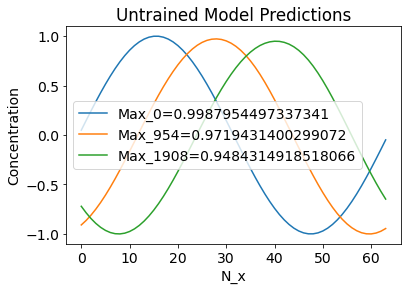

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)
Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 15s 8ms/sample - loss: 3.5749e-05
Epoch 2/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 1.9517e-05
Epoch 3/20
1899/1899 [==============================] - 9s 5ms/sample - loss: 1.9294e-05
Epoch 4/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 1.5648e-05
Epoch 5/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 1.6019e-05
Epoch 6/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 1.5146e-05
Epoch 7/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 1.1208e-05
Epoch 8/20
1899/1899 [==============================] - 14s 7ms/sample - loss: 1.4711e-05
Epoch 9/20
1899/1899 [===========

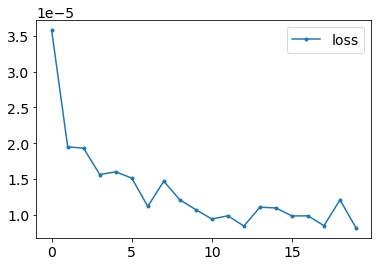

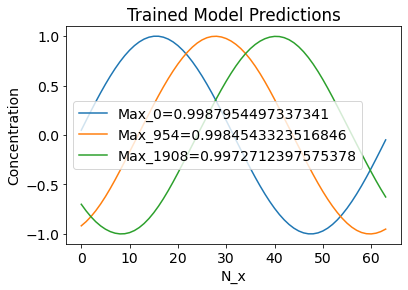

In [10]:
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
'Untrained'
integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

'Training'
ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
# train_output.shape
model_nn.compile(optimizer='adam', loss='mae')
history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True)
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

'Trained'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')


## Understand model_nn layer by layer

In [18]:
'Library conv2dstack takes kernel_size as tuple'
'Input--initial_state dict 3 key values of shape 1x64x1 each'
'output--tensor of shape 1x64x1xnum_outputs'
model1=models.conv2d_stack(num_outputs=15,num_layers=5,filters=32, kernel_size=(5,1),activation='relu')
model1(initial_state).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(15)])

In [ ]:

def cnn_out_to_diff(x,state,eq,stencil_size,total_acc,constr_acc,grid):
  parent=eq.find_base_key('concentration_x')
  kdef=eq.key_definitions['concentration_x']
  pardef=eq.key_definitions[parent]
  sten=models.build_stencils(kdef, pardef,stencil_size, grid.step)[0:1]
  deriv_ls=[1]
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc) #totalacc=4,constracc=1
  coeff_disc=pa(x) # 1,64,1,5
  fn_values=tensor_ops.extract_patches_2d(state['concentration'],(stencil_size,1),[0,0])
  diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
  return diff

In [19]:
'Now Output of CNN = 1x64x1xnum_outputs '

'Get alphas of shape 1,64,1,5 after passing through polynomial accuracy layer'

'Get alphas of shape 1,64,1,5 after passing through polynomial accuracy layer'

# Model_new

In [ ]:
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
'Untrained'
integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

'Training'
ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
# train_output.shape
model_nn.compile(optimizer='adam', loss='mae')
history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True)
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

'Trained'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')


## Understand model_new layer by layer

# Pol Acc layer

## Define advection eqn in 1-D

In [ ]:
from datadrivenpdes.core import equations
from datadrivenpdes.core import states
class adv1d(equations.Equation):

    DISCRETIZATION_NAME = 'finite_difference'
    METHOD = polynomials.Method.FINITE_DIFFERENCE
    MONOTONIC = False
    CONTINUOUS_EQUATION_NAME = 'Advection-1d'

    key_definitions = {
        'concentration': states.StateDefinition(name='concentration',
                      tensor_indices=(),
                      derivative_orders=(0,0,0),
                      offset=(0,0)),
        'concentration_x': states.StateDefinition(name='concentration',
                         tensor_indices=(),
                         derivative_orders=(1, 0, 0),
                         offset=(0, 0)),

    }
    evolving_keys = {'concentration'}
    constant_keys = set()

    def __init__(self, u, timestep=1e-4):
        self._timestep = timestep
        self.u=u
        super().__init__()
    
    def time_derivative(
          self, grid, concentration, concentration_x,):
        """See base class."""
        advA=-self.u*concentration_x

        return {'concentration': advA,}

    def get_time_step(self):
        return self._timestep


## Define Polynomial Acc function

In [ ]:
from typing import Any, Iterator, Optional, Sequence, Tuple
import enum
class Method(enum.Enum):
  """Discretization method."""
  FINITE_DIFFERENCE = 1
  FINITE_VOLUME = 2
class PolynomialAccuracy(tf.keras.layers.Layer):
  def __init__(self,stencils: Sequence[np.ndarray],method: Method,derivative_orders: Sequence[int],accuracy_order: int = 1,
               bias_accuracy_order: Optional[int] = 2,grid_step: float = None,bias: np.ndarray = None,dtype: Any = np.float32,):

    A, b = polynomials.constraints(stencils, method, derivative_orders, accuracy_order, grid_step)

    if bias is None:
      bias_grid = polynomials.coefficients(stencils, method, derivative_orders,bias_accuracy_order,grid_step)
      bias = bias_grid.ravel()

    norm = np.linalg.norm(np.dot(A, bias) - b)
    if norm > 1e-8:
      raise ValueError('invalid bias, not in nullspace')
    # https://en.wikipedia.org/wiki/Kernel_(linear_algebra)#Nonhomogeneous_systems_of_linear_equations
    _, _, v = np.linalg.svd(A)
    input_size = A.shape[1] - A.shape[0]
    if not input_size:
      raise ValueError(  # pylint: disable=g-doc-exception
          'there is only one valid solution accurate to this order')

    # nullspace from the SVD is always normalized such that its singular values
    # are 1 or 0, which means it's actually independent of the grid spacing.
    nullspace = v[-input_size:]
    # nullspace /= (grid_step**np.array(derivative_orders)).prod()

    self.input_size = input_size
    self.output_size = b.size
    self.nullspace = tf.convert_to_tensor(nullspace, dtype)
    self.bias = tf.convert_to_tensor(bias, dtype)

    super().__init__(trainable=False, dtype=dtype)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1] + (self.output_size,)

  def call(self, x: tf.Tensor) -> tf.Tensor:
    # TODO(geraschenko): explore projecting out the nullspace from full rank
    # inputs instead.
    return self.bias + tf.tensordot(x, self.nullspace, axes=[-1, 0])

def cnn_out_to_diff(x,state,eq,stencil_size,total_acc,constr_acc,grid):
  parent=eq.find_base_key('concentration_x')
  kdef=eq.key_definitions['concentration_x']
  pardef=eq.key_definitions[parent]
  sten=models.build_stencils(kdef, pardef,stencil_size, grid.step)[0:1]
  deriv_ls=[1]
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc) #totalacc=4,constracc=1
  coeff_disc=pa(x) # 1,64,1,5
  fn_values=tensor_ops.extract_patches_2d(state['concentration'],(stencil_size,1),[0,0])
  diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
  return diff




## Define model_nn custom class


In [ ]:
class myPseudoLinearModel(models.SpatialDerivativeModel):
  """Learn pseudo-linear filters for spatial derivatives."""

  def __init__(self, equation, grid,stencil_size=5, initial_accuracy_order=4,constrained_accuracy_order=1, 
               learned_keys=None,fixed_keys=None, core_model_func=models.conv2d_stack,num_time_steps=1, 
               geometric_transforms=None,predict_permutations=True, target=None,name='pseudo_linear_model',
               num_layers=None,filters=None,kernel_size=None,**kwargs):

    super().__init__(equation, grid, num_time_steps, target, name)
    self.learned_keys, self.fixed_keys = (
        models.normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.fd_model = models.FiniteDifferenceModel(
        equation, grid, initial_accuracy_order)
    self.geometric_transforms = geometric_transforms or [geometry.Identity()]
    self.equation=equation
    self.stencil_size=stencil_size
    self.initial_accuracy_order=initial_accuracy_order
    self.constrained_accuracy_order=constrained_accuracy_order
    self.grid=grid
    num_outputs = 1
    self.core_model = core_model_func(num_outputs,num_layers,filters,kernel_size)
    self.num_time_steps =num_time_steps
  def _apply_model(self, state):
    net = self.core_model(state)
    # result = {}
    # result['concentration_x']=
    derivative=cnn_out_to_diff(x=net,state=state,eq=self.equation,stencil_size=self.stencil_size,
                                              total_acc=self.initial_accuracy_order,constr_acc=self.constrained_accuracy_order,
                                              grid=self.grid)
    return derivative

  def spatial_derivatives(self,state):
  #   'INPUTS here refers to state at time = t itself'
  #   """See base class."""
    deriv=self._apply_model(state)
  #   result['concentration']=state
    return deriv
  
  # def next_time(self,state):
  #   C_x=self._apply_model(state)
  #   C=state['concentration']
  #   dt=self.equation.get_time_step()
  #   u0=self.equation.u
  #   Ct1=C+dt*(-u0)*(C_x)
  #   return Ct1

  def state_time_progression(self,state):
    C_x=self._apply_model(state)
    C=state['concentration']
    dt=self.equation.get_time_step()
    u0=self.equation.u
    Ct1=C+dt*(-u0)*(C_x)
    state['concentration']=Ct1
    return state

  def __call__(self,state) :
    # takes state_dict as input 
    #  Outputs 1 10 64 1 tensor of next 10 time-steps prediction
    ls=[] 
    for i in range(self.num_time_steps):
      new_state=self.state_time_progression(state)
      ls.append(new_state['concentration'])
      state['concentration']=new_state['concentration']
    return tf.stack(ls,1)


def integrate_func(ml_model,init_state,N_t):
  ls=[]
  ls.append(init_state)
  state=init_state
  for i in range(N_t-1):
    new_state=ml_model.state_time_progression(state)
    ls.append(new_state)
    state['concentration']=new_state['concentration']
  tens=tf.stack([st['concentration'] for st in ls])
  return tens

## Run nn model

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)
concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)
Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 16s 8ms/sample - loss: 8.0059e-05
Epoch 2/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 4.1107e-05
Epoch 3/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 3.6147e-05
Epoch 4/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 2.8954e-05
Epoch 5/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 2.1349e-05
Epoch 6/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 1.6820e-05
Epoch 7/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.5601e-05
Epoch 8/20
1899/1899 [=============================

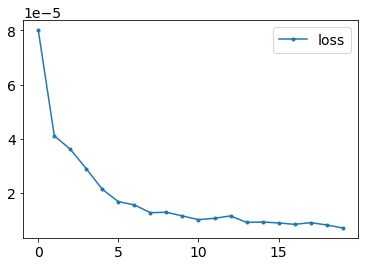

In [ ]:

res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)

eq=adv1d(u=1.,timestep=dt)
model_new=myPseudoLinearModel(eq,fine_grid,initial_accuracy_order=1,num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5,
                              filters=32,constrained_accuracy_order=1,learned_keys = {'concentration_x'}, activation='relu',)
integrated_UT1 =integrate_func(model_new,initial_state,N_t) 

# model1=models.conv2d_stack(num_outputs=10,num_layers=5,filters=32, kernel_size=5,activation='relu')
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
# integrated_UT1 = integrate.integrate_steps(model_new, initial_state, time_steps)

# integrate.integrate_steps(model_new, initial_state, time_steps)
# model_new(initial_state).shape

# num_ts=10
# tr_ot=[data_ana[n+1:n+1+num_ts] for n in range(data_ana.shape[0]-num_ts)]
# train_out=tf.expand_dims(tf.stack(tr_ot),-1)

ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
# train_output.shape


model_new.compile(
    optimizer='adam', loss='mae'
    )
history = model_new.fit(
    train_input, train_output, epochs=20, batch_size=64, 
    verbose=1, shuffle=True
    )
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

integrated_T1 =integrate_func(model_new,initial_state,N_t) 
# eq.METHOD

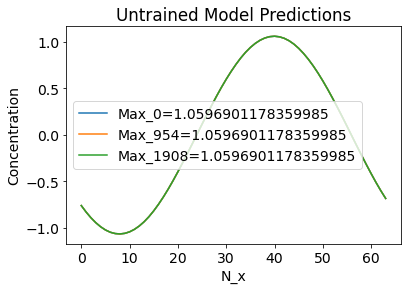

In [ ]:
plot_time_prop(integrated_UT1.numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

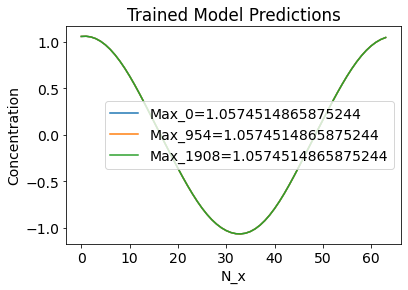

In [ ]:
plot_time_prop(integrated_T1.numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

In [ ]:
# integrated_T1 =integrate_func(model_new,initial_state,N_t) 

In [ ]:
# integrated_T1

In [ ]:
# print(integrated_UT1.shape)
print(integrated_T1.shape)

(1909, 1, 64, 1)


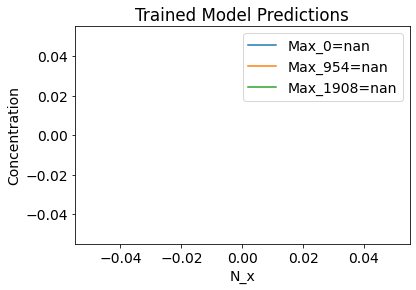

In [ ]:
plot_time_prop(integrated_T1.numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

In [ ]:

'Training'


# 'Trained Evaluation'
# integrated_T1 = integrate.integrate_steps(model_new, initial_state, time_steps)
# plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

# Extra

In [ ]:
time_steps

array([   0,    1,    2, ..., 1906, 1907, 1908])

In [ ]:
N_t

1909

In [ ]:
data_ana.shape

(1909, 64)

In [ ]:
x1=tf.random.normal((4,3))
x1

<tf.Tensor: id=5652, shape=(4, 3), dtype=float32, numpy=
array([[ 0.7845366 ,  0.6408813 ,  0.84214914],
       [ 0.7555685 , -0.5476298 , -1.2876854 ],
       [ 1.0618627 ,  0.8838861 ,  0.45848173],
       [-0.41089776, -0.22246045,  0.19069491]], dtype=float32)>

In [ ]:
y1=[x1[n+1:n+3] for n in range(x1.shape[0]-2)]


In [ ]:
data_ana.shape

(1909, 64)

In [ ]:
train_.shape

TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
train_output.shape

TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
# data_ana[12]

In [ ]:
# train_[1,9]

In [ ]:
# train_output[0]

In [ ]:
# train_output.shape

In [ ]:
# tensor_ops.extract_patches_2d(x1,(1,3))

## Other

In [ ]:
C=tf.random.normal([1,64,1])
C_x=tf.random.normal([1,64,1])
C.shape

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

In [ ]:
C[0,5,0]+2*C_x[0,5,0]

<tf.Tensor: id=892, shape=(), dtype=float32, numpy=-4.59622>

In [ ]:
model_nn(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
C+2*C_x

<tf.Tensor: id=881, shape=(1, 64, 1), dtype=float32, numpy=
array([[[-4.8519197 ],
        [ 1.5317459 ],
        [ 6.4321737 ],
        [-1.1136216 ],
        [ 3.1771643 ],
        [-4.59622   ],
        [ 2.5000083 ],
        [-2.360616  ],
        [ 1.6756575 ],
        [-1.0248947 ],
        [ 0.63709027],
        [-0.0526471 ],
        [-0.6731414 ],
        [ 3.2047815 ],
        [-0.12782848],
        [ 4.274591  ],
        [ 0.27686012],
        [ 1.4495835 ],
        [-1.9317409 ],
        [ 1.1848243 ],
        [-1.2650529 ],
        [-5.450883  ],
        [ 2.5511758 ],
        [-0.5686015 ],
        [ 3.5568252 ],
        [ 0.38146305],
        [-3.454869  ],
        [-2.9400244 ],
        [-2.295728  ],
        [ 1.4712894 ],
        [ 0.930304  ],
        [-1.7182789 ],
        [-2.5482135 ],
        [-0.5852704 ],
        [-3.1339984 ],
        [ 0.6543433 ],
        [-2.8173738 ],
        [ 0.08251542],
        [ 0.39510828],
        [ 3.8264875 ],
        [ 2.743671  

In [ ]:
print(type(model_nn.spatial_derivatives(initial_state)))
print(len(model_nn.spatial_derivatives(initial_state)))

<class 'dict'>
5


In [ ]:
for key,layer in model_nn.spatial_derivatives(initial_state).items():
  print(key,layer.shape)
print('\n')
print(model_nn.fixed_keys)
print('\n')
print(model_nn.learned_keys)

concentration_x (1, 64, 1)
concentration_y (1, 64, 1)
y_velocity (1, 64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)


{'y_velocity', 'concentration', 'x_velocity'}


{'concentration_x', 'concentration_y'}


In [ ]:
model_new._apply_model(initial_state)

{'concentration_x': <tf.Tensor: id=232, shape=(1, 64, 1), dtype=float32, numpy=
 array([[[ 0.9987244 ],
         [ 0.9891286 ],
         [ 0.97000694],
         [ 0.94148517],
         [ 0.9038912 ],
         [ 0.857653  ],
         [ 0.8031532 ],
         [ 0.74094665],
         [ 0.6715859 ],
         [ 0.59575963],
         [ 0.5141812 ],
         [ 0.42764813],
         [ 0.33699194],
         [ 0.24308077],
         [ 0.14681871],
         [ 0.04915363],
         [-0.04898063],
         [-0.14665642],
         [-0.24293627],
         [-0.33689013],
         [-0.4276013 ],
         [-0.51420486],
         [-0.59584147],
         [-0.6717381 ],
         [-0.7411705 ],
         [-0.8034521 ],
         [-0.8579818 ],
         [-0.9042061 ],
         [-0.94165814],
         [-0.97004986],
         [-0.98911697],
         [-0.9986806 ],
         [-0.99863815],
         [-0.9889947 ],
         [-0.9698718 ],
         [-0.9414687 ],
         [-0.9039649 ],
         [-0.85772806],
        

In [ ]:
model_new.spatial_derivatives(initial_state).keys()

dict_keys(['concentration_x', 'concentration'])

In [ ]:
# model_new(initial_state)

In [ ]:
for key,layer in model_new.spatial_derivatives(initial_state).items():
  print(key,layer.shape)
print('\n')
print(model_new.fixed_keys)
print('\n')
print(model_new.learned_keys)

UnimplementedError: ignored

In [ ]:
eq1=advection_equations.FiniteDifferenceAdvection(0.08)
print('\n')
print(model_new.fixed_keys)
print('\n')
print(model_new.learned_keys)



{'concentration'}


{'concentration_x'}


In [ ]:
a={'a':1}
a['b']=2
a

{'a': 1, 'b': 2}

## Model NN

In [ ]:

res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)

eq=adv1d(u=1.,timestep=dt)
model_new=myPseudoLinearModel(eq,fine_grid,initial_accuracy_order=4,num_time_steps=10,stencil_size=5, kernel_size=(5,1), num_layers=5,
                              filters=32,constrained_accuracy_order=1,learned_keys = {'concentration_x'}, activation='relu',)
# model1=models.conv2d_stack(num_outputs=10,num_layers=5,filters=32, kernel_size=5,activation='relu')
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
# integrated_UT1 = integrate.integrate_steps(model_new, initial_state, time_steps)
# model_new(initial_state)


# eq.METHOD

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


In [ ]:
# model_new(initial_state).shape
model_nn(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
# m1=models.conv2d_stack(10)
m1=models.conv2d_stack(num_outputs = 52, num_layers=5, filters=32, kernel_size=(5,1),activation='relu')
m1(initial_state)

<tf.Tensor: id=248896, shape=(1, 64, 1, 52), dtype=float32, numpy=
array([[[[-0.04318703,  0.05679173, -0.01612784, ...,  0.02285251,
          -0.07625276,  0.08105466]],

        [[-0.04066245,  0.05989677, -0.01546579, ...,  0.02317052,
          -0.07551247,  0.08955614]],

        [[-0.03798689,  0.06292473, -0.01471325, ...,  0.02341055,
          -0.07673727,  0.09638999]],

        ...,

        [[-0.03284486,  0.03903769, -0.01294035, ...,  0.01320301,
          -0.06256963,  0.05702941]],

        [[-0.03952498,  0.04640746, -0.01597773, ...,  0.01711109,
          -0.06952607,  0.06689336]],

        [[-0.04369004,  0.05262476, -0.01491428, ...,  0.02160431,
          -0.07552485,  0.0753458 ]]]], dtype=float32)>

In [ ]:
len(model_new._apply_model(initial_state))

1

In [ ]:
model_new._apply_model(initial_state)['concentration_x'].shape

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

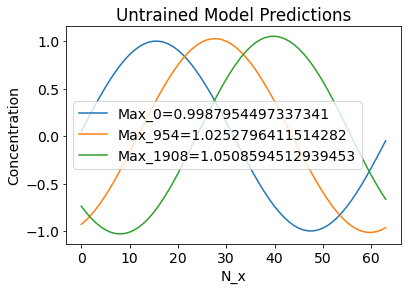

In [ ]:
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')


In [ ]:
model_nn.__call__(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
model_new.call(initial_state)

ValueError: ignored

In [ ]:

'Training'
ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
train_output.shape

# model_new.compile(
#     optimizer='adam', loss='mae'
#     )
# history = model_new.fit(
#     train_input, train_output, epochs=20, batch_size=64, 
#     verbose=1, shuffle=True
#     )
# df_history = pd.DataFrame(history.history)
# df_history.plot(marker='.')
# plt.show()

# 'Trained Evaluation'
# integrated_T1 = integrate.integrate_steps(model_new, initial_state, time_steps)
# plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
print(type(train_input))
print(len(train_input))
print(train_input.keys())
for key,tens in train_input.items():
  print(key,tens.shape)
# train_input['concentration']
# train_input['y_velocity'][50]

<class 'dict'>
3
dict_keys(['concentration', 'x_velocity', 'y_velocity'])
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)


## Old Important trials

In [ ]:

cnn_out_to_diff(x=x,state=initial_state,eq=eq,stencil_size=5,total_acc=4,constr_acc=1,grid=fine_grid)

In [ ]:
[1,2,3,4][1:2]

In [ ]:
ol=models.build_output_layers(equation=eq, grid=fine_grid, learned_keys={'concentration_x'}, stencil_size=5, initial_accuracy_order=4
                    ,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,
                    predict_permutations=True)

In [ ]:
for k,l in ol.items():
  print(k)

In [ ]:
for k,l in ol.items():
  l([x, initial_state['concentration']])

In [ ]:
fine_grid.step

In [ ]:
dx

In [ ]:
x=tf.random.normal([1,64,1,1])
def cnn_out_to_diff(x,eq,stencil_size,total_acc,constr_acc,grid):
  parent=eq.find_base_key('concentration_x')
  kdef=eq.key_definitions['concentration_x']
  pardef=eq.key_definitions[parent]
  sten=models.build_stencils(kdef, pardef, 5, 2.)
  # x=tf.random.normal([1,64,1,3])
  '1st grid step matters 2nd doesnt'
  pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4)
sten=[np.array([-2,-1.,0. ,1.,2])*0.5]
# 0.5 is dx here
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=3,bias_accuracy_order = 4)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=1000)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=0)
coeff_=pa(x)
coeff_.shape
# fn_=tensor_ops.extract_patches_2d(initial_state['concentration'],(5,1),[0,0])
# coeff=tf.squeeze(coeff_)
# coeff_.shape
# fn_.shape
# tf.einsum('bxys,bxys->bxy', coeff_, fn_).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(5)])

## Create Custom Poly Acc layer

In [ ]:
dt

0.007853981633974483

In [ ]:
eq1=advection_equations.FiniteDifferenceAdvection(0.08)
# eq.METHOD

# adv1d has no cfl input?
eq=adv1d(u=1.,timestep=dt)
eq.METHOD

<Method.FINITE_DIFFERENCE: 1>

In [ ]:
# eq.find_base_key('concentrationknlkn')
# eq.find_base_key('concentration_knlkn')
parent=eq.find_base_key('concentration_x')
kdef=eq.key_definitions['concentration_x']
pardef=eq.key_definitions[parent]
stc=models.build_stencils(kdef, pardef, 5, 2.)

In [ ]:

stc

[array([-4., -2.,  0.,  2.,  4.]), array([-4., -2.,  0.,  2.,  4.])]

In [ ]:
fine_grid.step

0.09817477042468103

In [ ]:
[k - p for p, k in zip(pardef.offset, kdef.offset)]

[0, 0]

(1, 0)

In [ ]:
polynomials.constraint_layer(stc,eq.METHOD,kdef.derivative_orders[:2],1,2,fine_grid.step)

In [ ]:
model_nn.learned_keys

{'concentration_x', 'concentration_y'}

In [ ]:
eq1

In [ ]:
initial_state['concentration'].shape

(1, 64, 1)

In [ ]:
eq1.all_keys

{'concentration',
 'concentration_x',
 'concentration_y',
 'x_velocity',
 'y_velocity'}

In [ ]:
x=tf.random.normal([1,64,1,3])
'1st grid step matters 2nd doesnt'
sten=[np.array([-2,-1.,0. ,1.,2])*0.5]
# 0.5 is dx here
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=1000)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=0)
coeff_=pa(x)
coeff_.shape
# fn_=tensor_ops.extract_patches_2d(initial_state['concentration'],(5,1),[0,0])
# coeff=tf.squeeze(coeff_)
# coeff_.shape
# fn_.shape
# tf.einsum('bxys,bxys->bxy', coeff_, fn_).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(5)])

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

In [ ]:
initial_state['concentration'][0][:5]

array([[0.04906768],
       [0.14673047],
       [0.24298018],
       [0.33688986],
       [0.42755508]], dtype=float32)

In [ ]:

vcl=models.VaryingCoefficientsLayer(pa,sten,[0],'concentration')
vcl(x)

In [ ]:
ol=models.build_output_layers(equation=eq, grid=fine_grid, learned_keys={'concentration_x'}, stencil_size=5, initial_accuracy_order=4
                    ,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,
                    predict_permutations=True)
print([layer.kernel_size for layer in ol.values()])

[22]


In [ ]:
x=tf.random.normal([1,64,1,22])
for k,layer in ol.items():
  print(layer([x, initial_state['concentration']]))
  # print(k,layer)

InvalidArgumentError: ignored

In [ ]:
class myPseudoLinear(models.SpatialDerivativeModel):
  """Learn pseudo-linear filters for spatial derivatives."""

  def __init__(self, equation, grid, stencil_size=5, initial_accuracy_order=2,constrained_accuracy_order=1, learned_keys=None,
               fixed_keys=None, core_model_func=models.conv2d_stack,num_time_steps=1, geometric_transforms=None,
               predict_permutations=True,target=None,name='pseudo_linear_model', **kwargs):
    """Initialize class.
    Args:
      core_model_func: callable (function or class object). It should return a Keras model (or layer) instance, which contains trainable weights.
        The returned core_model instance should take a dict of tensors as input
        (see the call() method in the base TimeStepModel class).
        Additional kwargs are passed to this callable to specify hyperparameters
        of core_model (such as number of layers and convolutional filters).
    """

    super().__init__(equation, grid, num_time_steps, target, name)

    self.learned_keys, self.fixed_keys = (models.normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))

    self.polyacc=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constrained_accuracy_order ,bias_accuracy_order = initial_accuracy_order)

    # self.output_layers = models.build_output_layers(equation, grid, self.learned_keys, stencil_size, initial_accuracy_order,
    #                                          constrained_accuracy_order, layer_cls=models.VaryingCoefficientsLayer,
    #                                          predict_permutations=predict_permutations)

    # self.fd_model = models.FiniteDifferenceModel(equation, grid, initial_accuracy_order)

    # self.geometric_transforms = geometric_transforms or [geometry.Identity()]
    self.num_outputs=initial_accuracy_order-constrained_accuracy_order
    # num_outputs = sum(layer.kernel_size for layer in self.output_layers.values())
    self.core_model = core_model_func(self.num_outputs, **kwargs)

  def _apply_model(self, state):
    net = self.core_model(state)

    # size_splits = [self.output_layers[key].kernel_size for key in self.output_layers]
    # heads = tf.split(net, size_splits, axis=-1)
    
    result={}
    
    
    # result = {}
    # for (key, layer), head in zip(self.output_layers.items(), heads):
    #   input_tensor = state[layer.input_key]
    #   result[key] = layer([head, input_tensor])

    # return result
    return net

  # def spatial_derivatives(self, inputs):
  #   """See base class."""
  #   result = models.average_over_transforms(self._apply_model, self.geometric_transforms, inputs)
  #   if self.fixed_keys:
  #     result.update(self.fd_model.spatial_derivatives(inputs, self.fixed_keys))
  #   return result


model_nn = myPseudoLinear(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=2,
                                    num_time_steps=10,stencil_size=5, kernel_size=(5,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
model_nn._apply_model(initial_state)

<tf.Tensor: id=355757, shape=(1, 64, 1, 56), dtype=float32, numpy=
array([[[[-0.02409362, -0.07265262,  0.00679261, ...,  0.06090643,
          -0.08190176, -0.0449761 ]],

        [[-0.0239966 , -0.07664052,  0.00602177, ...,  0.0557516 ,
          -0.08161802, -0.04391564]],

        [[-0.02282128, -0.07948752,  0.00380843, ...,  0.05209965,
          -0.08141782, -0.04025207]],

        ...,

        [[-0.02854399, -0.05719436,  0.01049389, ...,  0.08256464,
          -0.08077292, -0.04455323]],

        [[-0.02844786, -0.06260958,  0.01047198, ...,  0.07427159,
          -0.08342962, -0.04675319]],

        [[-0.02613103, -0.06816138,  0.00850751, ...,  0.06747038,
          -0.08367244, -0.04539395]]]], dtype=float32)>

In [ ]:
def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = models.Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(models.Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model

NameError: ignored

In [ ]:
# c1=models.conv2d_stack(56)
# c1(initial_state)

coreModel = models.conv2d_stack(num_outputs = 52, num_layers=5, filters=32, kernel_size=3,activation='relu')
print(coreModel(initial_state).shape)

(1, 64, 1, 52)


In [ ]:
from typing import Any, Iterator, Optional, Sequence, Tuple
import enum
class Method(enum.Enum):
  """Discretization method."""
  FINITE_DIFFERENCE = 1
  FINITE_VOLUME = 2
class PolynomialAccuracy(tf.keras.layers.Layer):
  def __init__(self,stencils: Sequence[np.ndarray],method: Method,derivative_orders: Sequence[int],accuracy_order: int = 1,
               bias_accuracy_order: Optional[int] = 2,grid_step: float = None,bias: np.ndarray = None,dtype: Any = np.float32,):

    A, b = polynomials.constraints(stencils, method, derivative_orders, accuracy_order, grid_step)

    if bias is None:
      bias_grid = polynomials.coefficients(stencils, method, derivative_orders,bias_accuracy_order,grid_step)
      bias = bias_grid.ravel()

    norm = np.linalg.norm(np.dot(A, bias) - b)
    if norm > 1e-8:
      raise ValueError('invalid bias, not in nullspace')
    # https://en.wikipedia.org/wiki/Kernel_(linear_algebra)#Nonhomogeneous_systems_of_linear_equations
    _, _, v = np.linalg.svd(A)
    input_size = A.shape[1] - A.shape[0]
    if not input_size:
      raise ValueError(  # pylint: disable=g-doc-exception
          'there is only one valid solution accurate to this order')

    # nullspace from the SVD is always normalized such that its singular values
    # are 1 or 0, which means it's actually independent of the grid spacing.
    nullspace = v[-input_size:]
    # nullspace /= (grid_step**np.array(derivative_orders)).prod()

    self.input_size = input_size
    self.output_size = b.size
    self.nullspace = tf.convert_to_tensor(nullspace, dtype)
    self.bias = tf.convert_to_tensor(bias, dtype)

    super().__init__(trainable=False, dtype=dtype)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1] + (self.output_size,)

  def call(self, x: tf.Tensor) -> tf.Tensor:
    # TODO(geraschenko): explore projecting out the nullspace from full rank
    # inputs instead.
    return self.bias + tf.tensordot(x, self.nullspace, axes=[-1, 0])

In [ ]:
x=tf.random.normal([1,64,1,1])
sten=[np.array([-1.,0. ,1.])]
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 2)
pa(x).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(3)])

In [ ]:
pa(x).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(3)])

In [ ]:
sten[0].size

3

In [ ]:
x1=tf.random.normal([64,1])

In [ ]:
x1[0:5]

<tf.Tensor: id=9743, shape=(5, 1), dtype=float32, numpy=
array([[ 0.23986126],
       [-0.27079737],
       [ 0.0665032 ],
       [-0.3504073 ],
       [-0.10848822]], dtype=float32)>

In [ ]:
tensor_ops.extract_patches_2d(x1,(3,1),[0,0])

<tf.Tensor: id=9739, shape=(64, 1, 3), dtype=float32, numpy=
array([[[ 0.9785932 ,  0.23986126, -0.27079737]],

       [[ 0.23986126, -0.27079737,  0.0665032 ]],

       [[-0.27079737,  0.0665032 , -0.3504073 ]],

       [[ 0.0665032 , -0.3504073 , -0.10848822]],

       [[-0.3504073 , -0.10848822,  0.3728615 ]],

       [[-0.10848822,  0.3728615 , -0.74167466]],

       [[ 0.3728615 , -0.74167466,  0.87641513]],

       [[-0.74167466,  0.87641513, -1.3101739 ]],

       [[ 0.87641513, -1.3101739 , -0.6633319 ]],

       [[-1.3101739 , -0.6633319 , -0.8992759 ]],

       [[-0.6633319 , -0.8992759 ,  0.48382887]],

       [[-0.8992759 ,  0.48382887, -0.89950347]],

       [[ 0.48382887, -0.89950347, -2.0493016 ]],

       [[-0.89950347, -2.0493016 , -1.528964  ]],

       [[-2.0493016 , -1.528964  ,  0.20724452]],

       [[-1.528964  ,  0.20724452,  1.0501851 ]],

       [[ 0.20724452,  1.0501851 , -0.1453674 ]],

       [[ 1.0501851 , -0.1453674 , -1.8612638 ]],

       [[-0.1453674 ,

In [ ]:
vcl=models.VaryingCoefficientsLayer(pa,sten,[0],'concentration')
vcl(x)

In [ ]:
x=tf.random.normal([1,64,1,3])
sten=[np.array([-2,-1.,0. ,1.,2])]
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=3,bias_accuracy_order = 4)
pa(x).shape

InvalidArgumentError: ignored

## Constraint

In [ ]:
sten=[np.array([-1.,0. ,1.])]
deriv=1
met=polynomials.Method.FINITE_DIFFERENCE
for acc in range(1,3):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
  print(f'A is {A}\n')
  print(f'b is {b}\n \n')

This is constrained acc order = 1
No. of rows is 1(deriv)+1(acc) = 2
A is [[-1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0.]
 

This is constrained acc order = 2
No. of rows is 1(deriv)+2(acc) = 3
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0. 0.]
 



In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2])]
deriv=1
for acc in range(1,5):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
  print(f'A is {A}\n')
  print(f'b is {b}\n \n')

This is constrained acc order = 1
No. of rows is 1(deriv)+1(acc) = 2
A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]]

b is [1. 0.]
 

This is constrained acc order = 2
No. of rows is 1(deriv)+2(acc) = 3
A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [1. 0. 0.]
 

This is constrained acc order = 3
No. of rows is 1(deriv)+3(acc) = 4
A is [[-8. -1.  0.  1.  8.]
 [-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [0. 1. 0. 0.]
 

This is constrained acc order = 4
No. of rows is 1(deriv)+4(acc) = 5
A is [[-8. -1.  0.  1.  8.]
 [-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]
 [16.  1.  0.  1. 16.]]

b is [0. 1. 0. 0. 0.]
 



In [ ]:
sten=[np.array([-1.,0. ,1.])]
deriv=2
for acc in range(1,3):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[deriv],stencils=sten,grid_step=0.25)
  print(f'A is {A}\n')
  print(f'b is {b}\n \n')

This is constrained acc order = 1
No. of rows is 2(deriv)+1(acc) = 3
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [0. 2. 0.]
 

This is constrained acc order = 2
No. of rows is 2(deriv)+2(acc) = 4
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [0. 2. 0.]
 



## Coefficient function

In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2])]
for gd in [0.25,0.5,1.5]:
  coeff = polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[2],grid_step=gd)
  print(coeff)

[-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]
[-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]
[-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]


In [ ]:
p=np.array([2])
2**p

array([4])

In [ ]:
a=tf.convert_to_tensor(np.arange(12).reshape(3,4))
print(a)
b=tf.convert_to_tensor(np.arange(20).reshape(4,5))
print(b)
print(a@b)
print(tf.tensordot(a,b,axes=[-1, 0]))

tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]], shape=(3, 4), dtype=int64)
tf.Tensor(
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]], shape=(4, 5), dtype=int64)
tf.Tensor(
[[ 70  76  82  88  94]
 [190 212 234 256 278]
 [310 348 386 424 462]], shape=(3, 5), dtype=int64)
tf.Tensor(
[[ 70  76  82  88  94]
 [190 212 234 256 278]
 [310 348 386 424 462]], shape=(3, 5), dtype=int64)


In [ ]:
a=tf.random.normal([3,4])
print(a)
b=tf.convert_to_tensor(np.arange(20.).reshape(4,5),dtype=tf.float32)
print(b)
print(a@b)
print(tf.tensordot(a,b,axes=[-1, 0]))

tf.Tensor(
[[-0.23892407  0.11206634 -0.3930344   1.3621991 ]
 [-0.96918243  0.8720763   1.5442923   0.03735123]
 [ 0.76392263 -0.23340526 -0.55307394 -1.4784018 ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]], shape=(4, 5), dtype=float32)
tf.Tensor(
[[ 17.062975  17.905281  18.747587  19.589895  20.432201]
 [ 20.363573  21.84811   23.33265   24.817184  26.301722]
 [-28.873793 -30.37475  -31.87571  -33.376667 -34.877625]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 17.062975  17.905281  18.747587  19.589895  20.432201]
 [ 20.363573  21.84811   23.33265   24.817184  26.301722]
 [-28.873793 -30.37475  -31.87571  -33.376667 -34.877625]], shape=(3, 5), dtype=float32)


In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2])]
deriv=1
for acc in range(1,5):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
  coeff = polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[deriv],grid_step=0.25)
  print(f'coeff is {coeff} \n')
  print(f'A is {A}\n')
  print(f'b is {b}\n')
  print(A@coeff -b)
  print('\n \n')

This is constrained acc order = 1
No. of rows is 1(deriv)+1(acc) = 2
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333] 

A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]]

b is [1. 0.]

[-1.11022302e-16  0.00000000e+00]

 

This is constrained acc order = 2
No. of rows is 1(deriv)+2(acc) = 3
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333] 

A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [1. 0. 0.]

[-1.11022302e-16  0.00000000e+00  0.00000000e+00]

 

This is constrained acc order = 3
No. of rows is 1(deriv)+3(acc) = 4
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333] 

A is [[-8. -1.  0.  1.  8.]
 [-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [0. 1. 0. 0.]

[ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00]

 

This is constrained acc order = 4
No. of rows is 1(deriv)+4(acc) = 5
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.083

In [ ]:
sten=[np.array([-1.,0. ,1.])]
for acc in range(1,3):
  print('This is constrained acc order')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
# coeff = polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[1],grid_step=0.25)
# print(f'coeff are {np.squeeze(coeff)}\n')
# norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
# print(f'Norm is {norm}')
  print(f'A is {A}\n')
  print(f'b is {b}\n')
# coff_solve=np.linalg.solve(A,b)
# print(f'x=AinvB=x={coff_solve}\n')

# _, _, v = np.linalg.svd(A)
# print(f'v is {v}\n')


This is constrained acc order
A is [[-1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0.]

This is constrained acc order
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0. 0.]



In [ ]:
if 1.2:
  print('Hello')

Hello


In [ ]:
polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[1],grid_step=0.25)

array([-0.5,  0. ,  0.5])

In [ ]:
bias_grid = coefficients(stencils, method, derivative_orders,bias_accuracy_order, grid_step)

In [ ]:
x=tf.random.normal([1,64,1,3])

sten=[np.array([-1.,0. ,1.]),np.array([-1.,0. ,1.])]
fd=polynomials.Method.FINITE_DIFFERENCE
deriv=[1,0]
poly_layer=polynomials.PolynomialAccuracy(stencils=sten,method=fd,derivative_orders=deriv,accuracy_order=1,grid_step=0.5)
poly_layer(x)

InvalidArgumentError: ignored

InvalidArgumentError: ignored

TypeError: ignored


# Pol Acc

In [ ]:
A = np.matrix([[1,3], [1,2], [1, -1], [2,1]])
rank = np.linalg.matrix_rank(A)
# U, s, V = np.linalg.svd(A, full_matrices = True)
U, s, V = np.linalg.svd(A, full_matrices = False)
print(f"rank is {rank}\n")
print(f'U shape is is {U.shape}\n')
print(f'Sigma shape is {s.shape}\n')
print(f'V shape is {V.shape}\n')

# t_U_A = np.transpose(U)
# nrow = t_U_A.shape[0]
# left_null_A = t_U_A[rank:nrow,:]
# left_null_A
# np.dot((left_null_A[0,:] + left_null_A[0,:]), A)



rank is 2

U shape is is (4, 2)

Sigma shape is (2,)

V shape is (2, 2)



In [ ]:
not 5

False

In [ ]:
not 0

True

In [ ]:
snew=np.zeros((4,2))
snew[0,0]=s[0]
snew[1,1]=s[1]
snew

array([[4.26744684, 0.        ],
       [0.        , 1.94650904],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [ ]:
U@snew@V

matrix([[ 1.,  3.],
        [ 1.,  2.],
        [ 1., -1.],
        [ 2.,  1.]])

In [ ]:

# Right null:

B = np.transpose(A)
rank = np.linalg.matrix_rank(B)
U, s, V = np.linalg.svd(B, full_matrices = True)
t_V_B = np.transpose(V)
ncols = t_V_B.shape[1]
right_null_B = t_V_B[:,rank:ncols]
right_null_B
np.dot(B, (right_null_B[:,0] + right_null_B[:,1]))

In [ ]:
FINITE_DIFF = polynomials.Method.FINITE_DIFFERENCE
stencil=[-1, 0, 1]
coeff = polynomials.coefficients([np.array(stencil)], FINITE_DIFF,[1])
coeff

array([-0.5,  0. ,  0.5])

In [ ]:
# a, b = polynomials.constraints([np.array([-0.5, 0.5])],method,derivative_orders=[0],accuracy_order=accuracy_order,grid_step=1.0)

In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2.])]
A,b=polynomials.constraints(accuracy_order=2,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
coeff = polynomials.coefficients(sten, FINITE_DIFF,[1],grid_step=0.25)
print(f'coeff are {np.squeeze(coeff)}\n')
norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
print(f'Norm is {norm}')
print(f'A is {A}\n')
print(f'b is {b}\n')
coff_solve=np.linalg.solve(A,b)
print(f'x=AinvB=x={coff_solve}\n')

_, _, v = np.linalg.svd(A)
print(f'v is {v}\n')

coeff are [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333]

Norm is 1.1102230246251565e-16
A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [1. 0. 0.]



LinAlgError: ignored

In [ ]:
sten=[np.array([-1.,0.,1.]),np.array([0])]
A,b=polynomials.constraints(accuracy_order=2,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1,0], stencils= sten )
coeff = polynomials.coefficients(sten, FINITE_DIFF,derivative_orders=[1,0],grid_step=0.25)
_, _, v = np.linalg.svd(A)
# print(f'v is {v}\n')
print(f'coeff are {np.squeeze(coeff)}')
print(f'A is {A}')
print(f'b is {b}')
norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
print(f'Norm is {norm}')
# coff_solve=np.linalg.solve(A,b)
# print(f'x=AinvB=x={coff_solve}')
coeff.ravel()

coeff are [-0.5  0.   0.5]
A is [[-1.  0.  1.]
 [ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]
b is [1. 0. 0. 0.]
Norm is 0.0


array([-0.5,  0. ,  0.5])

In [ ]:
coeff

array([-0.5,  0. ,  0.5])

In [ ]:
2**coeff

array([0.70710678, 1.        , 1.41421356])

In [ ]:
sten=[np.array([-0.5 ,0.5]),np.array([-0.5 ,0.5])]
A,b=polynomials.constraints(accuracy_order=2,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[0,0], stencils= sten )
coeff = polynomials.coefficients(sten, FINITE_DIFF,derivative_orders=[0,0])
print(f'coeff are {np.squeeze(coeff)}')
print(f'A is {A}')
print(f'b is {b}')
norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
print(f'Norm is {norm}')

coeff are [[0.25 0.25]
 [0.25 0.25]]
A is [[-0.5 -0.5  0.5  0.5]
 [-0.5  0.5 -0.5  0.5]
 [ 1.   1.   1.   1. ]]
b is [0. 0. 1.]
Norm is 0.0


In [ ]:
np.dot(A, np.squeeze(coeff))

ValueError: ignored

In [ ]:
A.shape

(3, 4)

In [ ]:
coeff.flatten().shape

(4,)

In [ ]:
print(A@(coeff.flatten()))

[0. 0. 1.]


In [ ]:
print(A.dot([4 / 10, 1 / 10, 1 / 10, 4 / 10]))

[0. 0. 1.]


In [ ]:
[1,2,3,4]*2

[1, 2, 3, 4, 1, 2, 3, 4]

# Results

## Define & Initialize NN model

In [ ]:
res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)
# model1=models.conv2d_stack(num_outputs=10,num_layers=5,filters=32, kernel_size=5,activation='relu')
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
# integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
model_nn(initial_state).shape

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
print('Input to model_nn is dict initial_state \n with keys conc, x-vel y-vel') 
print(initial_state['concentration'].shape)
print('The _apply_model method outputs \n delc/dex array \n & \n delc/dey array')
print(model_nn._apply_model(initial_state).keys())
print(list(model_nn._apply_model(initial_state).values())[0].shape)
print(list(model_nn._apply_model(initial_state).values())[1].shape)

print(integrated_UT1['concentration'].shape)
'First analyze method _apply_model of PseudoLinearMode Class'
'Analyze core_model_func i.e. conv_2d_stack'

from typing import (
    Any, Dict, List, Optional, Mapping, Set, TypeVar, Tuple, Union,
)
T = TypeVar('T')
def sorted_values(x: Dict[Any, T]) -> List[T]:
  """Returns the sorted values of a dictionary."""
  return [x[k] for k in sorted(x)]

def stack_dict(state: Dict[Any, tf.Tensor]) -> tf.Tensor:
  """Stack a dict of tensors along its last axis."""
  return tf.stack(sorted_values(state), axis=-1)
  
def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = models.Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(models.Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model


  'Check function sorted_values'
  dc={'ab':456,'xy':1,'rt':1234}
  print(dc)
  print(sorted_values(dc))

'Check function stack_dict'
stack_ls=stack_dict(initial_state)
print(stack_dict(initial_state).shape)
'''Stacks initial_state concen,x-vel,y-vel in alphabetical order
along last axis'''
stack_dict(initial_state)[...,2].shape
'Check function entire conv2d_stack'
for i in range(20):
  coreModel = conv2d_stack(num_outputs = 3, num_layers=5, filters=32, kernel_size=3,
                  activation='relu')
  print(coreModel(initial_state).shape)
def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = models.Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(models.Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model
m1 = tf.keras.Sequential()
print(type(m1(initial_state)))
m1.add(tf.keras.layers.Lambda(stack_dict))
print(type(m1(initial_state)))
print(m1(initial_state).shape)
# layer1=models.Conv2DPeriodic(filters=9, kernel_size=(3.1), activation='relu')
layer1= tf.keras.layers.Conv2D(filters=9, kernel_size=(7,1), activation='relu')
m1.add(layer1)
print(m1(initial_state).shape)
'Analyze Conv2dPeriodic class '
in_sh=stack_ls.shape
print(in_sh)
print(in_sh[:-1]+(9,)) # For 9 filters used in convolution
stack_ls.shape
stack_ls[0,:,0,2]
# tensor_ops.pad_periodic_2d(stack_ls,))
padded_=tensor_ops._pad_periodic_by_axis(stack_ls, [1, 1],1)
print(padded_.shape)
padded_[0,:,0,2]

Input to model_nn is dict initial_state 
 with keys conc, x-vel y-vel
(1, 64, 1)
The _apply_model method outputs 
 delc/dex array 
 & 
 delc/dey array
dict_keys(['concentration_x', 'concentration_y'])
(1, 64, 1)
(1, 64, 1)
(1909, 1, 64, 1)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
<class 'dict'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 64, 1, 3)
(1, 58, 1, 9)
(1, 64, 1, 3)
(1, 64, 1, 9)
(1, 66, 1, 3)


<tf.Tensor: id=356592, shape=(66,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

## Post convolution

In [ ]:
print(model_nn.learned_keys)
print(model_nn.fixed_keys)
l,f=(models.normalize_learned_and_fixed_keys(model_nn.learned_keys, model_nn.fixed_keys,advection_equations.FiniteDifferenceAdvection(0.08)))
print(l)
print(f)
coreModel = conv2d_stack(num_outputs = 12, num_layers=5, filters=32, kernel_size=3,activation='relu')
print(coreModel(initial_state).shape)
for stenc in [11,5,7,9,3]:
  coreModel = conv2d_stack(num_outputs = 12, num_layers=5, filters=32, kernel_size=3,activation='relu')
  out_layers = models.build_output_layers(equation=advection_equations.FiniteDifferenceAdvection(0.08), grid=fine_grid, learned_keys=model_nn.learned_keys, stencil_size=stenc, 
                                          initial_accuracy_order=1,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,predict_permutations=True)
  print(type(out_layers))
  for key in out_layers:
    print(key)
  for key in out_layers:
    print(out_layers[key].kernel_size)
  size_splits = [out_layers[key].kernel_size for key in out_layers]
  size_splits

size_splits
net=coreModel(initial_state)
net.shape
heads = tf.split(net, size_splits, axis=-1)
print(type(heads))
print(len(heads))
print(heads[0].shape)
print(heads[1].shape)
out_layers
out_layers.items()
for key,layer in out_layers.items():
  print(key)
  print(layer)
  print('\n')
for head in heads:
  print(head.shape)
for (key, layer), head in zip(out_layers.items(), heads):
  print(key)
  print(layer)
  print(head.shape)
  print('\n')
for (key, layer), head in zip(out_layers.items(), heads):
  print(key)
  print(layer.input_key)
  print(head.shape)
  print('\n')
result = {}
for (key, layer), head in zip(out_layers.items(), heads):
  input_tensor = initial_state[layer.input_key]
  'Input tensor of shape 1,64,1'
  'polyAcc layer takes Input : '
  '(1, 64, 1, 118)-delc/delx '
  '(1, 64, 1     )-c '

  'result[concx] = gives delc/delx'
  'result[concy] = gives delc/dely'
  
  result[key] = layer([head, input_tensor])
print(type(result))
print(len(result))
for key,tens in result.items():
  print(key)
  print(tens.shape)
  print('\n')

{'concentration_x', 'concentration_y'}
{'y_velocity', 'x_velocity', 'concentration'}
{'concentration_x', 'concentration_y'}
{'y_velocity', 'x_velocity', 'concentration'}


## Create standard schemes data

In [ ]:
datu=upwind_data(linear=True,init=initial_state['concentration'].squeeze(),c=u0,ntime=N_t,N_x=len(x_fine),delt=dt,delx=dx)
datc=CD2_data(linear=True,init=initial_state['concentration'].squeeze(),c=u0,ntime=N_t,N_x=len(x_fine),delt=dt,delx=dx)

## At t = tend Compare 3 schemes

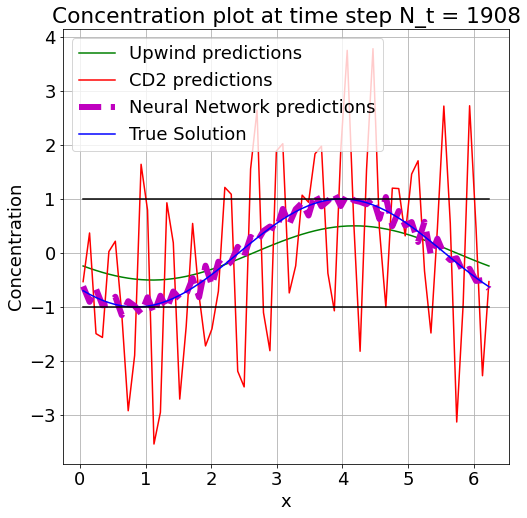

In [ ]:
def compare_t(nt):
  plt.rcParams.update({'font.size': 18})
  plt.figure(figsize=(8,8))
  plt.plot(x_fine,datu[nt],'g',label='Upwind predictions')
  plt.plot(x_fine,datc[nt],'r',label='CD2 predictions')
  plt.plot(x_fine,integrated_T1['concentration'].numpy().squeeze()[nt],'m',label='Neural Network predictions',linestyle='dashed',linewidth=6, markersize=12)
  plt.plot(x_fine,data_ana[nt],'b',label='True Solution')

  plt.plot(x_fine,-np.ones_like(x_fine),'k')
  plt.plot(x_fine,np.ones_like(x_fine),'k')
  plt.xlabel('x')
  plt.ylabel('Concentration')
  plt.legend()
  plt.grid()
  # plt.title(f'Concentration plot at time step N_t = {nt}',y=1.08)
  plt.title(f'Concentration plot at time step N_t = {nt}')
  # plt.tight_layout()
  plt.show()
compare_t(N_t-1)
# compare_t(30)
# compare_t(1000)
# compare_t(1500)


## Compare Amplitude progression with time for 3 schemes

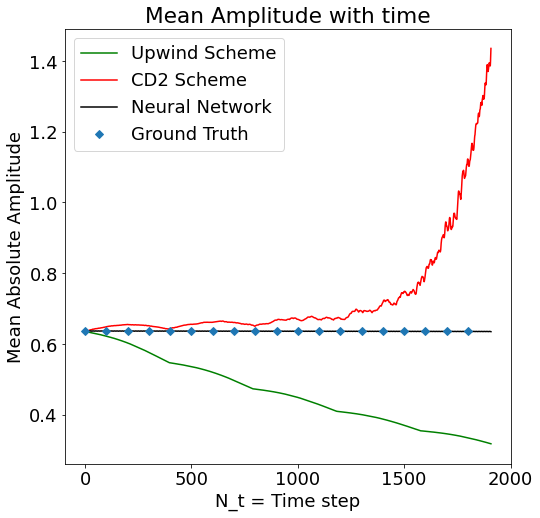

In [ ]:
ampUp_avg = np.stack([np.mean(np.abs(datu[i])) for i in range(N_t)])
ampCD_avg = np.stack([np.mean(np.abs(datc[i])) for i in range(N_t)])
ampNN_avg = np.stack([np.mean(np.abs(integrated_T1['concentration'].numpy().squeeze()[i])) for i in range(N_t)])
ampGround_avg = np.stack([np.mean(np.abs(data_ana[i])) for i in range(N_t)])

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8))
plt.plot(np.arange(N_t),ampUp_avg,'g',label='Upwind Scheme')
plt.plot(np.arange(N_t),ampCD_avg,'r',label='CD2 Scheme')
plt.plot(np.arange(N_t),ampNN_avg,'k',label='Neural Network')
markers_on = np.arange(0,1900,100).tolist()
plt.plot(np.arange(N_t),ampGround_avg,'D',markevery=markers_on,label='Ground Truth')
plt.ylabel('Mean Absolute Amplitude')
plt.xlabel('N_t = Time step')
plt.legend()
plt.title('Mean Amplitude with time')
plt.show()

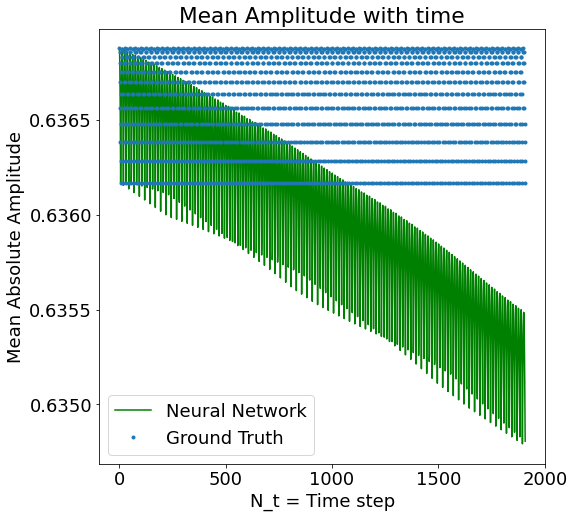

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8))
# plt.plot(np.arange(N_t),ampUp_avg,'g',label='Upwind Scheme')
# plt.plot(np.arange(N_t),ampCD_avg,'r',label='CD2 Scheme')
plt.plot(np.arange(N_t),ampNN_avg,'g',label='Neural Network')
plt.plot(np.arange(N_t),ampGround_avg,'.',label='Ground Truth')
plt.ylabel('Mean Absolute Amplitude')
plt.xlabel('N_t = Time step')
plt.legend()
plt.title('Mean Amplitude with time')
plt.show()

## Compare Order of Accuracy 

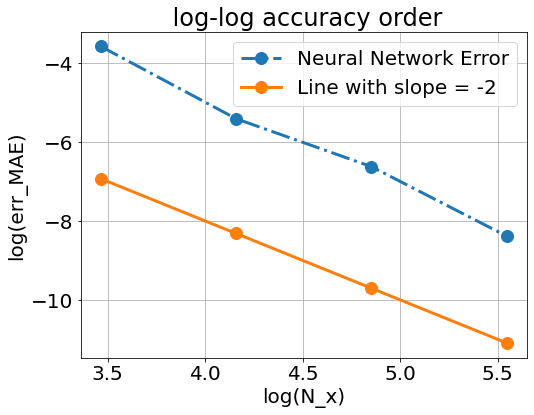

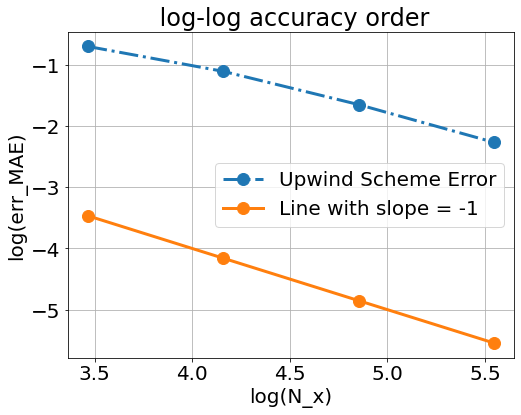

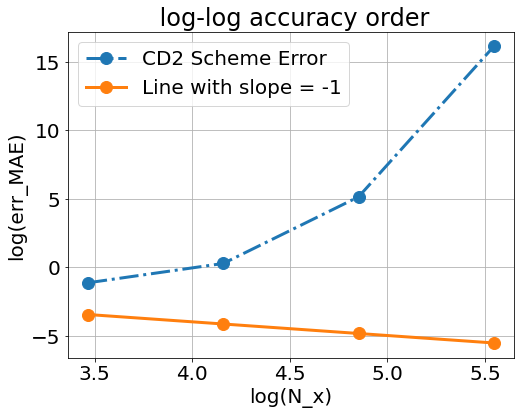

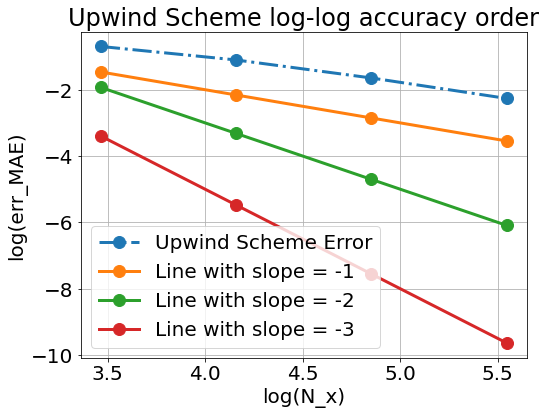

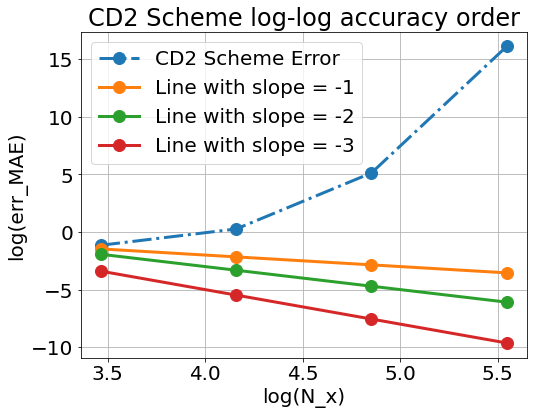

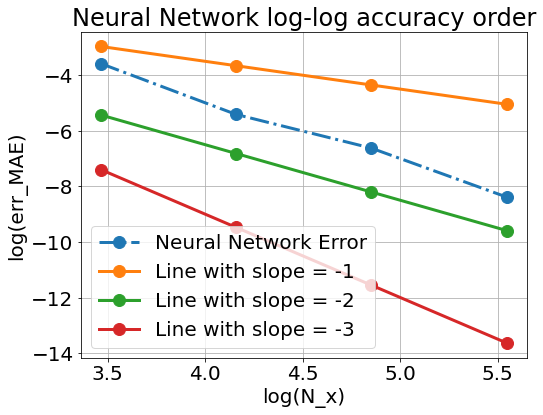

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
ne=np.loadtxt('nn')
ce=np.loadtxt('cd')
ue=np.loadtxt('up')
nl=2**(np.arange(5,9))
def OOA(x,y,m,c,mylabel='Neural Network Error'):
  plt.rcParams.update({'font.size': 20})
  plt.figure(figsize=(8,6))
  plt.plot(np.log(x),np.log(y),'o-',label=mylabel,linestyle='-.',linewidth=3, markersize=12)
  plt.plot(np.log(x),-m*np.log(x)+c,'o-',label=f'Line with slope = -{m}',linestyle='-',linewidth=3, markersize=12)
  plt.ylabel('log(err_MAE)')
  plt.xlabel('log(N_x)')
  plt.grid()
  plt.title(' log-log accuracy order')
  plt.legend()
  plt.show()

def OOA_loop(x,y,m_ls,c_ls,mylabel='Neural Network'):
  plt.rcParams.update({'font.size': 20})
  plt.figure(figsize=(8,6))
  plt.plot(np.log(x),np.log(y),'o-',label=mylabel+' Error',linestyle='-.',linewidth=3, markersize=12) 
  for i in range(len(m_ls)):
    plt.plot(np.log(x),-m_ls[i]*np.log(x)+c_ls[i],'o-',label=f'Line with slope = -{m_ls[i]}',linestyle='-',linewidth=3, markersize=12)
  plt.ylabel('log(err_MAE)')
  plt.xlabel('log(N_x)')
  plt.grid()
  plt.title(f'{mylabel} log-log accuracy order')
  plt.legend()
  plt.show()

OOA(nl,ne,2,0,'Neural Network Error')
OOA(nl,ue,1,0,'Upwind Scheme Error')
OOA(nl,ce,1,0,'CD2 Scheme Error')

OOA_loop(x=nl,y=ue,m_ls=[1,2,3],c_ls=[2,5,7],mylabel='Upwind Scheme')
OOA_loop(x=nl,y=ce,m_ls=[1,2,3],c_ls=[2,5,7],mylabel='CD2 Scheme')
OOA_loop(x=nl,y=ne,m_ls=[1,2,3],c_ls=[0.5,1.5,3],mylabel='Neural Network')


# Other ideas

In [ ]:
'N_x other than just powers of 2'
'''Mean solution amplitude with time 
MAE with time 
MAE with grid points increase'''